In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')


In [ ]:
# ===============================
# 2. Leitura dos Dados
# ===============================
from google.colab import files

uploaded = files.upload()
arquivo = list(uploaded.keys())[0]
df = pd.read_csv(arquivo)
df = df.iloc[::-1].reset_index(drop=True)

Saving Dados Históricos - Bitcoin (1).csv to Dados Históricos - Bitcoin (1).csv


In [ ]:
# ===============================
# 3. Limpeza dos Dados
# ===============================
def trata_volume(valor):
    valor = str(valor).strip().replace('.', '').replace(',', '.').replace('R$', '')
    if valor.endswith('K'):
        return float(valor[:-1]) * 1_000
    elif valor.endswith('M'):
        return float(valor[:-1]) * 1_000_000
    elif valor.endswith('B'):
        return float(valor[:-1]) * 1_000_000_000
    else:
        try:
            return float(valor)
        except:
            return np.nan

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)\
        .str.replace(',', '.', regex=False).astype(float)

df['Var%'] = df['Var%'].astype(str).str.replace('%', '', regex=False)\
    .str.replace(',', '.', regex=False).str.replace('−', '-', regex=False).astype(float)
df['Vol.'] = df['Vol.'].apply(trata_volume)

In [ ]:
# ===============================
# 4. Criação das Features
# ===============================
df['Vol_USD'] = df['Vol.'] * df['Último']
df['minima_amanha'] = df['Mínima'].shift(-1)
df['maxima_amanha'] = df['Máxima'].shift(-1)
df['media_movel_max_3'] = df['Máxima'].rolling(window=3).mean()
df['vol_relativo'] = df['Vol_USD'] / df['Vol_USD'].shift(1)
df['minima_rel_ultimo'] = (df['Mínima'] - df['Último'].shift(1)) / df['Último'].shift(1)

# Novas features
df['rompeu_topo_historico'] = df['Máxima'] > df['Máxima'].rolling(window=90).max().shift(1)
df['volume_relativo_7d'] = df['Vol_USD'] / df['Vol_USD'].rolling(7).mean()
df['var_pct_3d'] = df['Var%'].rolling(3).mean()


In [ ]:
# ===============================
# 5. Seleção de Dados
# ===============================
sub_df = df[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol_USD', 'Var%',
             'media_movel_max_3', 'vol_relativo', 'minima_rel_ultimo',
             'rompeu_topo_historico', 'volume_relativo_7d', 'var_pct_3d',
             'minima_amanha', 'maxima_amanha']].dropna()

X = sub_df.drop(columns=['minima_amanha', 'maxima_amanha'])
y_min = sub_df['minima_amanha']
y_max = sub_df['maxima_amanha']

In [ ]:
# ===============================
# 6. Split de Treino/Teste (70/30)
# ===============================
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_min_train, y_min_test = y_min[:split_idx], y_min[split_idx:]
y_max_train, y_max_test = y_max[:split_idx], y_max[split_idx:]

In [ ]:
# ===============================
# 7. Treinamento dos Modelos (Random Forest)
# ===============================
modelo_min = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
modelo_min.fit(X_train, y_min_train)

modelo_max = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
modelo_max.fit(X_train, y_max_train)

RandomForestRegressor(max_depth=4, random_state=42)

In [ ]:
# ===============================
# 8. Previsões
# ===============================
y_min_pred = modelo_min.predict(X_test)
y_max_pred = modelo_max.predict(X_test)

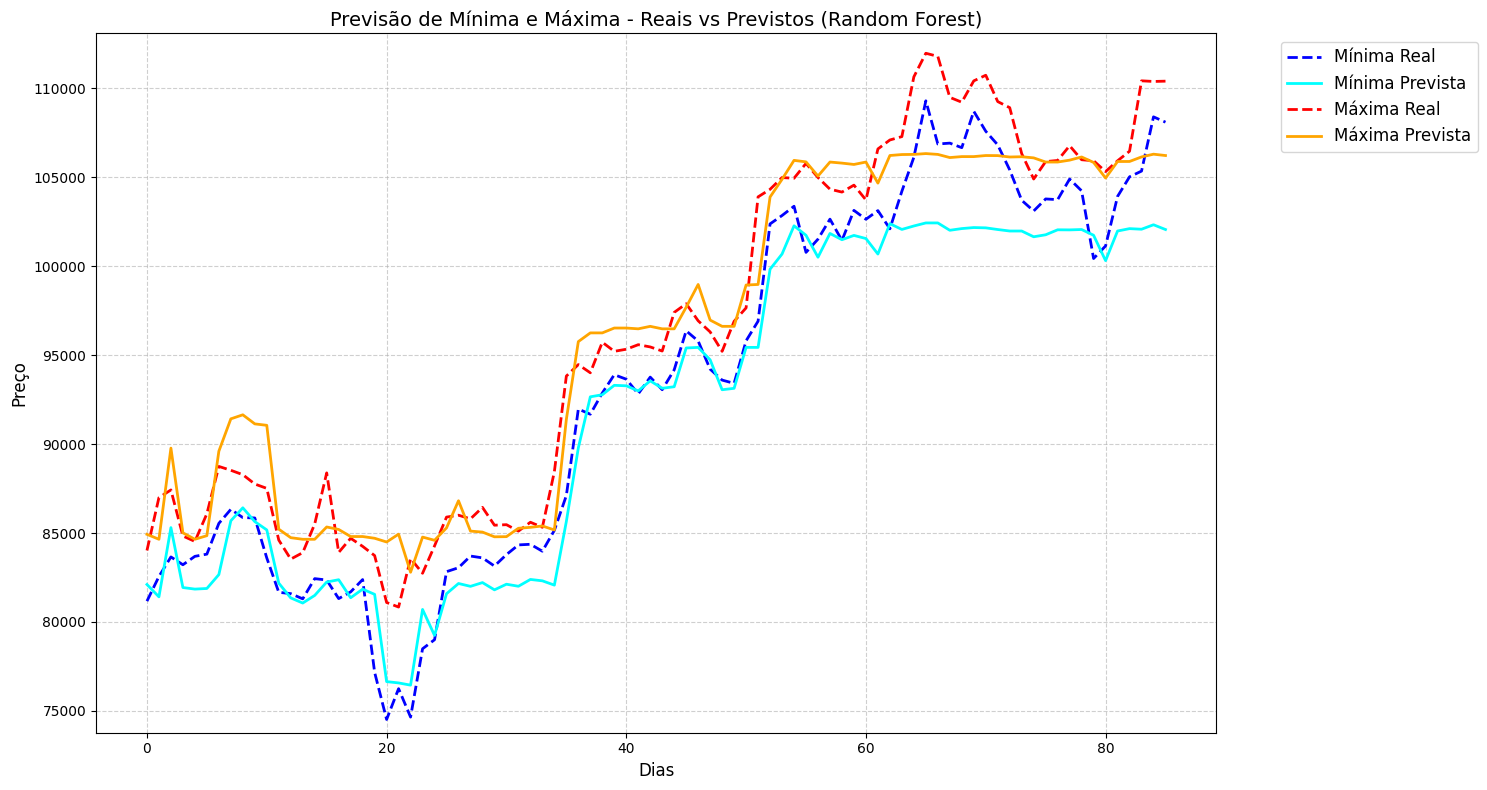

In [ ]:
# ===============================
# 9. Visualização dos Resultados
# ===============================
plt.figure(figsize=(15, 8))
y_min_plot = min(min(y_min_test), min(y_min_pred)) * 0.99
y_max_plot = max(max(y_max_test), max(y_max_pred)) * 1.01

plt.plot(y_min_test.values, label='Mínima Real', linestyle='--', linewidth=2, color='blue')
plt.plot(y_min_pred, label='Mínima Prevista', linewidth=2, color='cyan')
plt.plot(y_max_test.values, label='Máxima Real', linestyle='--', linewidth=2, color='red')
plt.plot(y_max_pred, label='Máxima Prevista', linewidth=2, color='orange')

plt.title('Previsão de Mínima e Máxima - Reais vs Previstos (Random Forest)', fontsize=14)
plt.xlabel('Dias', fontsize=12)
plt.ylabel('Preço', fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(y_min_plot, y_max_plot)
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# 10. Métricas
# ===============================
def calc_percent_erro(y_true, y_pred, pct):
    erro_rel = np.abs(y_true - y_pred) / y_true
    return (erro_rel <= pct/100).mean() * 100

mae_min = mean_absolute_error(y_min_test, y_min_pred)
erro_rel_min = mae_min / y_min_test.mean() * 100
r2_min = r2_score(y_min_test, y_min_pred) * 100
pct2_min = calc_percent_erro(y_min_test, y_min_pred, 2)
pct5_min = calc_percent_erro(y_min_test, y_min_pred, 5)

mae_max = mean_absolute_error(y_max_test, y_max_pred)
erro_rel_max = mae_max / y_max_test.mean() * 100
r2_max = r2_score(y_max_test, y_max_pred) * 100
pct2_max = calc_percent_erro(y_max_test, y_max_pred, 2)
pct5_max = calc_percent_erro(y_max_test, y_max_pred, 5)

print("========= MÉTRICAS (Random Forest) =========")
print(f"MAE Mínima: {mae_min:.2f}")
print(f"Erro Relativo Mínima (%): {erro_rel_min:.2f}")
print(f"R² Mínima (%): {r2_min:.2f}")
print(f"% Acerto ≤2% Mínima: {pct2_min:.2f}")
print(f"% Acerto ≤5% Mínima: {pct5_min:.2f}")
print("\n---\n")
print(f"MAE Máxima: {mae_max:.2f}")
print(f"Erro Relativo Máxima (%): {erro_rel_max:.2f}")
print(f"R² Máxima (%): {r2_max:.2f}")
print(f"% Acerto ≤2% Máxima: {pct2_max:.2f}")
print(f"% Acerto ≤5% Máxima: {pct5_max:.2f}")


========= MÉTRICAS (Random Forest) =========
MAE Mínima: 1785.31
Erro Relativo Mínima (%): 1.91
R² Mínima (%): 94.57
% Acerto ≤2% Mínima: 63.95
% Acerto ≤5% Mínima: 93.02

---

MAE Máxima: 1608.08
Erro Relativo Máxima (%): 1.67
R² Máxima (%): 95.31
% Acerto ≤2% Máxima: 67.44
% Acerto ≤5% Máxima: 97.67


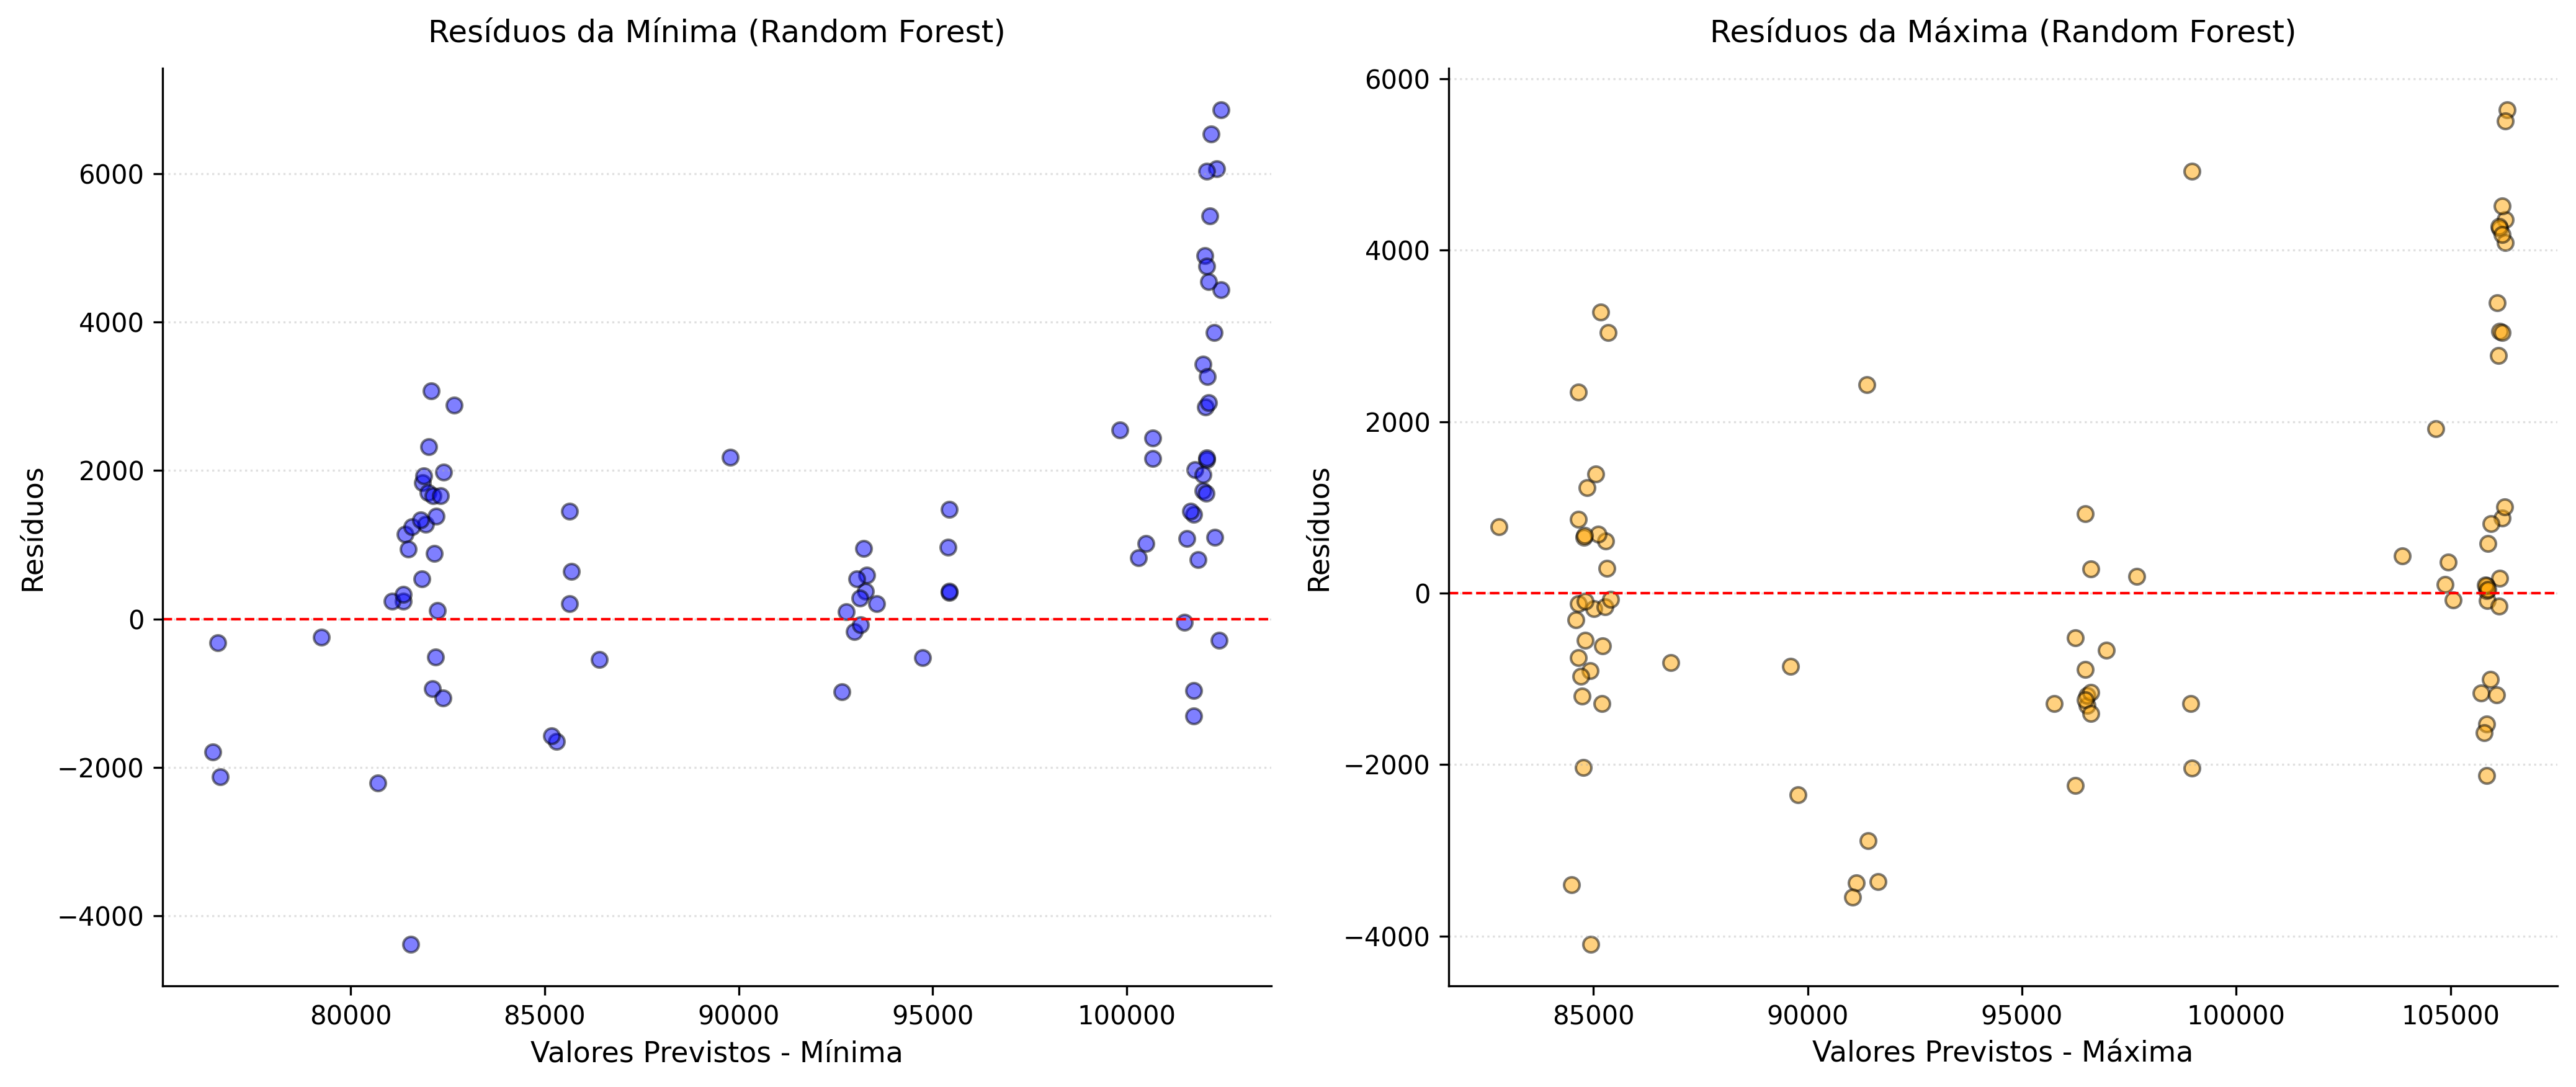

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ================================
# Configurações Visuais ABNT
# ================================
rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "grid.alpha": 0.4,
    "grid.linestyle": ":"
})

# ================================
# Plotagem dos Gráficos de Resíduos
# ================================
plt.figure(figsize=(14, 6), dpi=300)

# --- Resíduos da Mínima ---
plt.subplot(1, 2, 1)
plt.scatter(y_min_pred, residuos_min, alpha=0.5, color='blue', edgecolors='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Resíduos da Mínima (Random Forest)', pad=10)
plt.xlabel('Valores Previstos - Mínima')
plt.ylabel('Resíduos')

# Formatação estética ABNT
plt.grid(axis='y')
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# --- Resíduos da Máxima ---
plt.subplot(1, 2, 2)
plt.scatter(y_max_pred, residuos_max, alpha=0.5, color='orange', edgecolors='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Resíduos da Máxima (Random Forest)', pad=10)
plt.xlabel('Valores Previstos - Máxima')
plt.ylabel('Resíduos')

# Formatação estética ABNT
plt.grid(axis='y')
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Layout organizado
plt.tight_layout()
plt.show()


========== Estatísticas Descritivas ==========
                    count          mean           std           min  \
Último              284.0  8.738773e+04  1.537844e+04  5.396680e+04   
Abertura            284.0  8.720722e+04  1.540838e+04  5.396500e+04   
Máxima              284.0  8.885215e+04  1.560048e+04  5.481920e+04   
Mínima              284.0  8.561355e+04  1.512766e+04  5.264460e+04   
Vol_USD             284.0  7.967853e+09  5.014084e+09  1.663936e+09   
Var%                284.0  2.509859e-01  2.517716e+00 -8.550000e+00   
media_movel_max_3   284.0  8.867568e+04  1.558513e+04  5.569367e+04   
vol_relativo        284.0  1.136380e+00  6.170168e-01  2.420443e-01   
minima_rel_ultimo   284.0 -1.807193e-02  1.704775e-02 -9.679404e-02   
volume_relativo_7d  284.0  1.009124e+00  4.104862e-01  1.916164e-01   
var_pct_3d          284.0  2.456690e-01  1.399258e+00 -4.350000e+00   
minima_amanha       284.0  8.578721e+04  1.510139e+04  5.264460e+04   
maxima_amanha       284.0  8.9

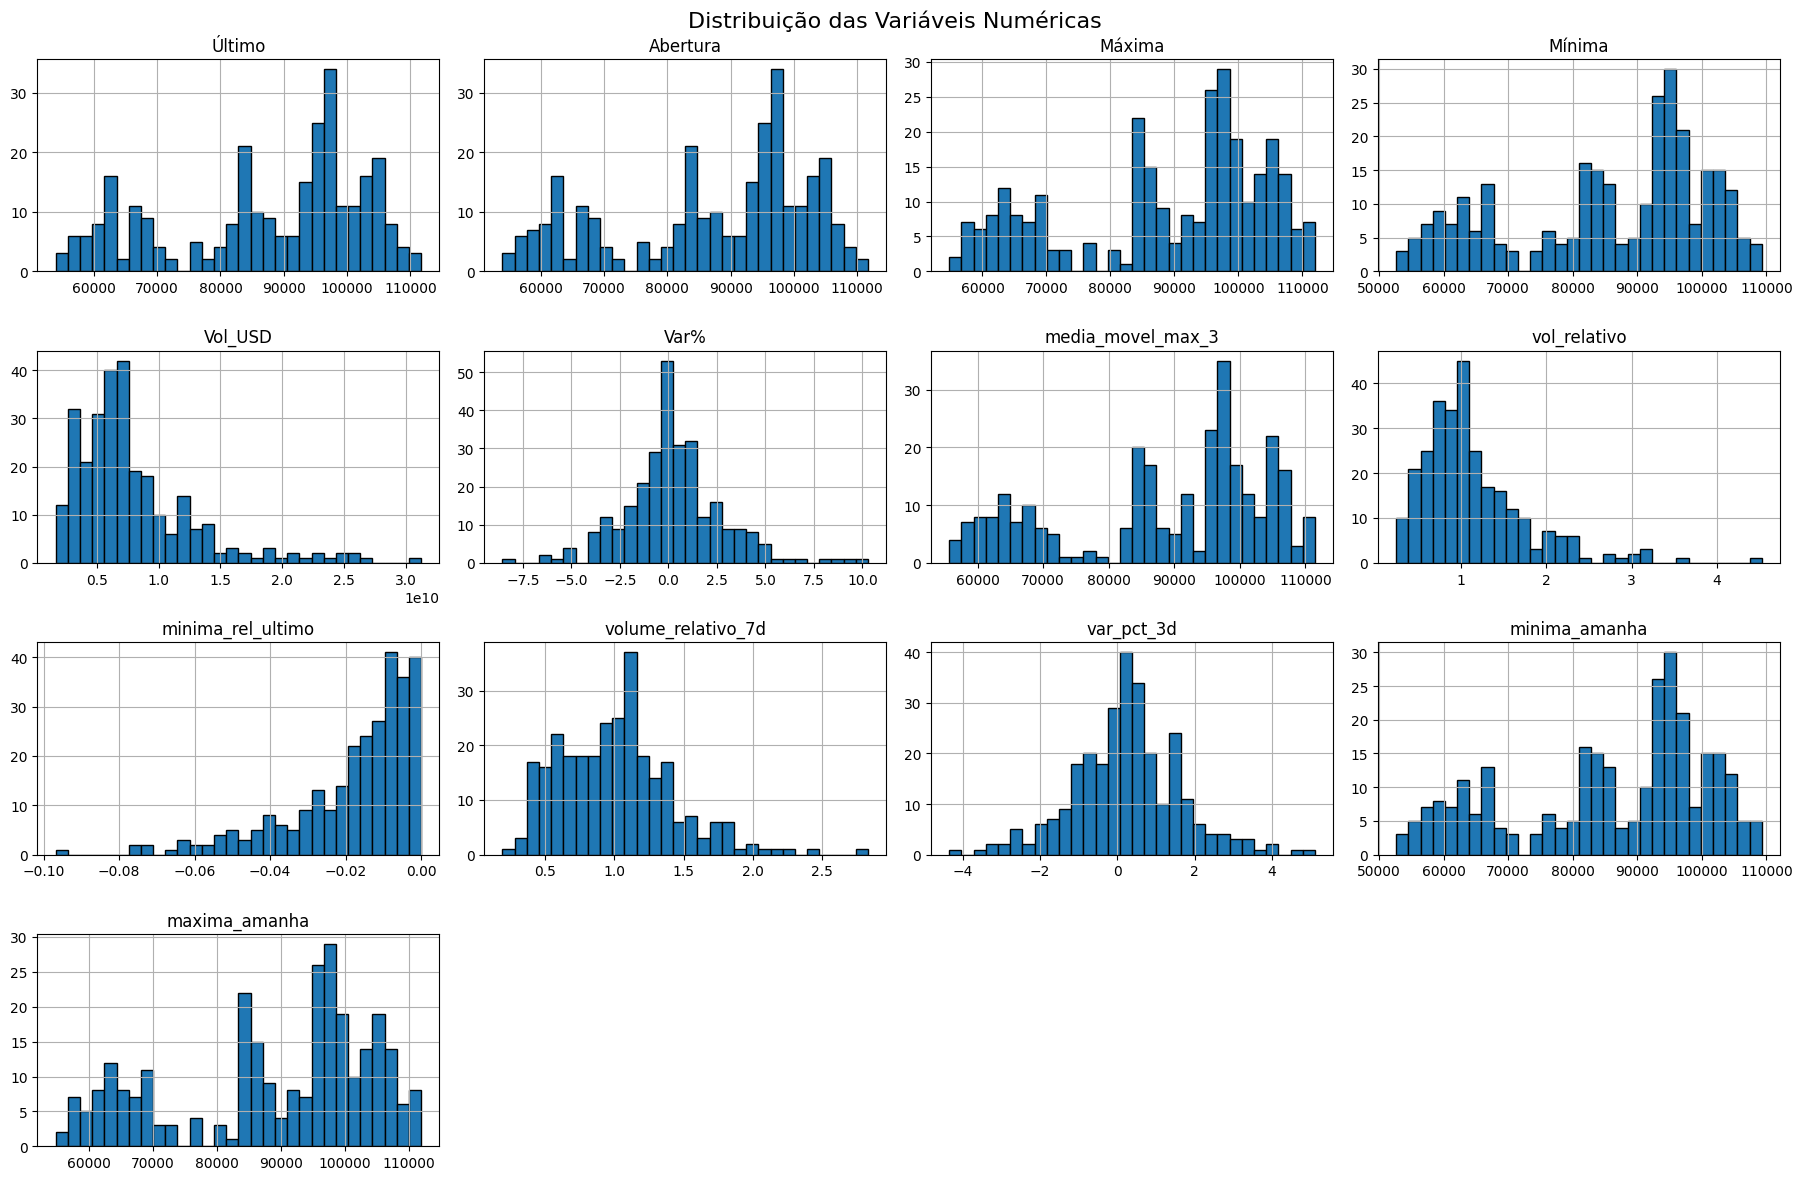

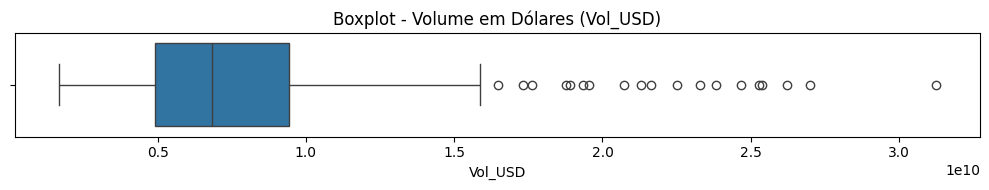

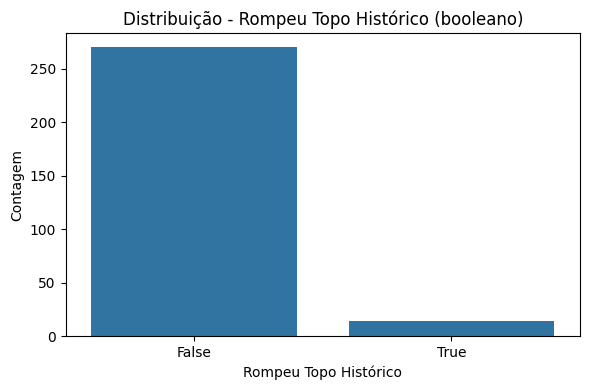

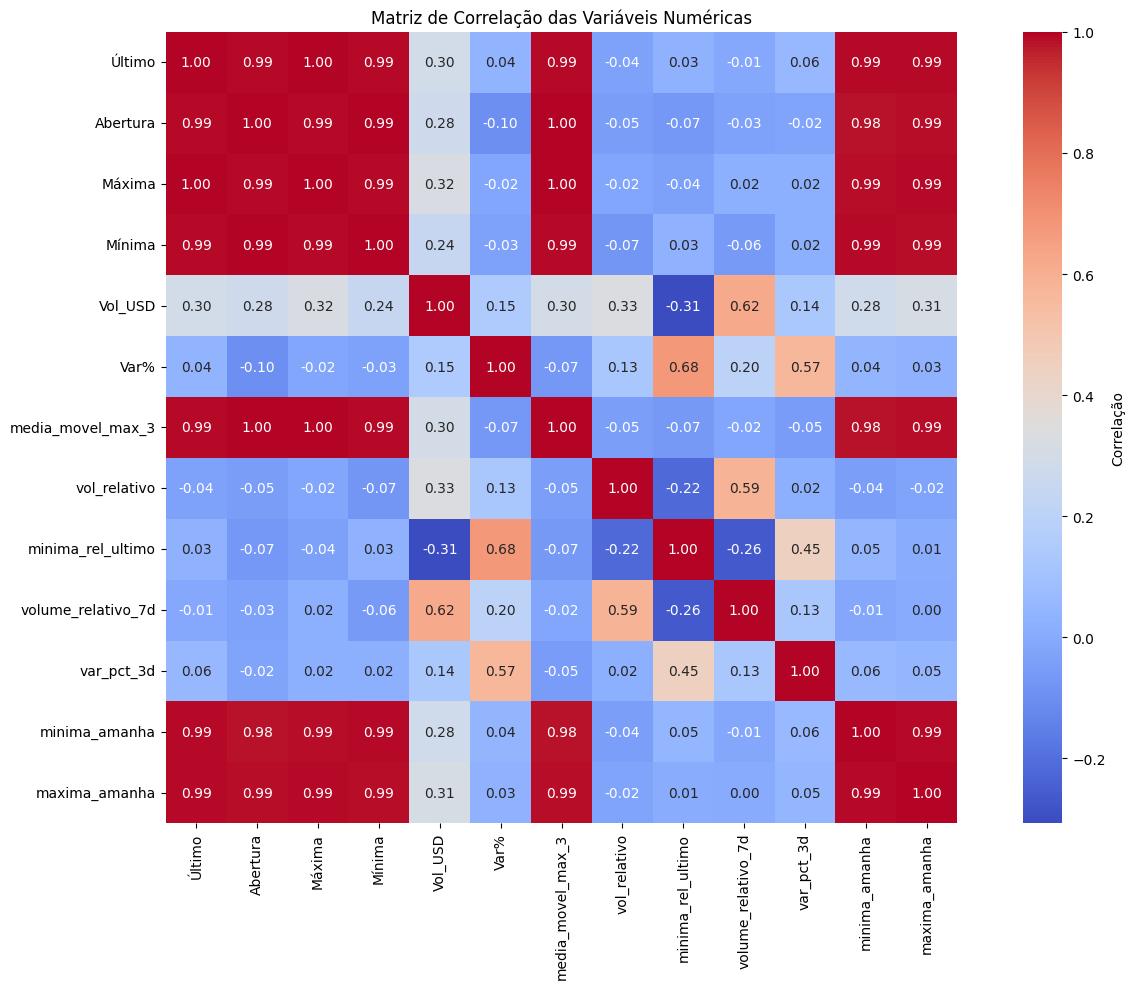

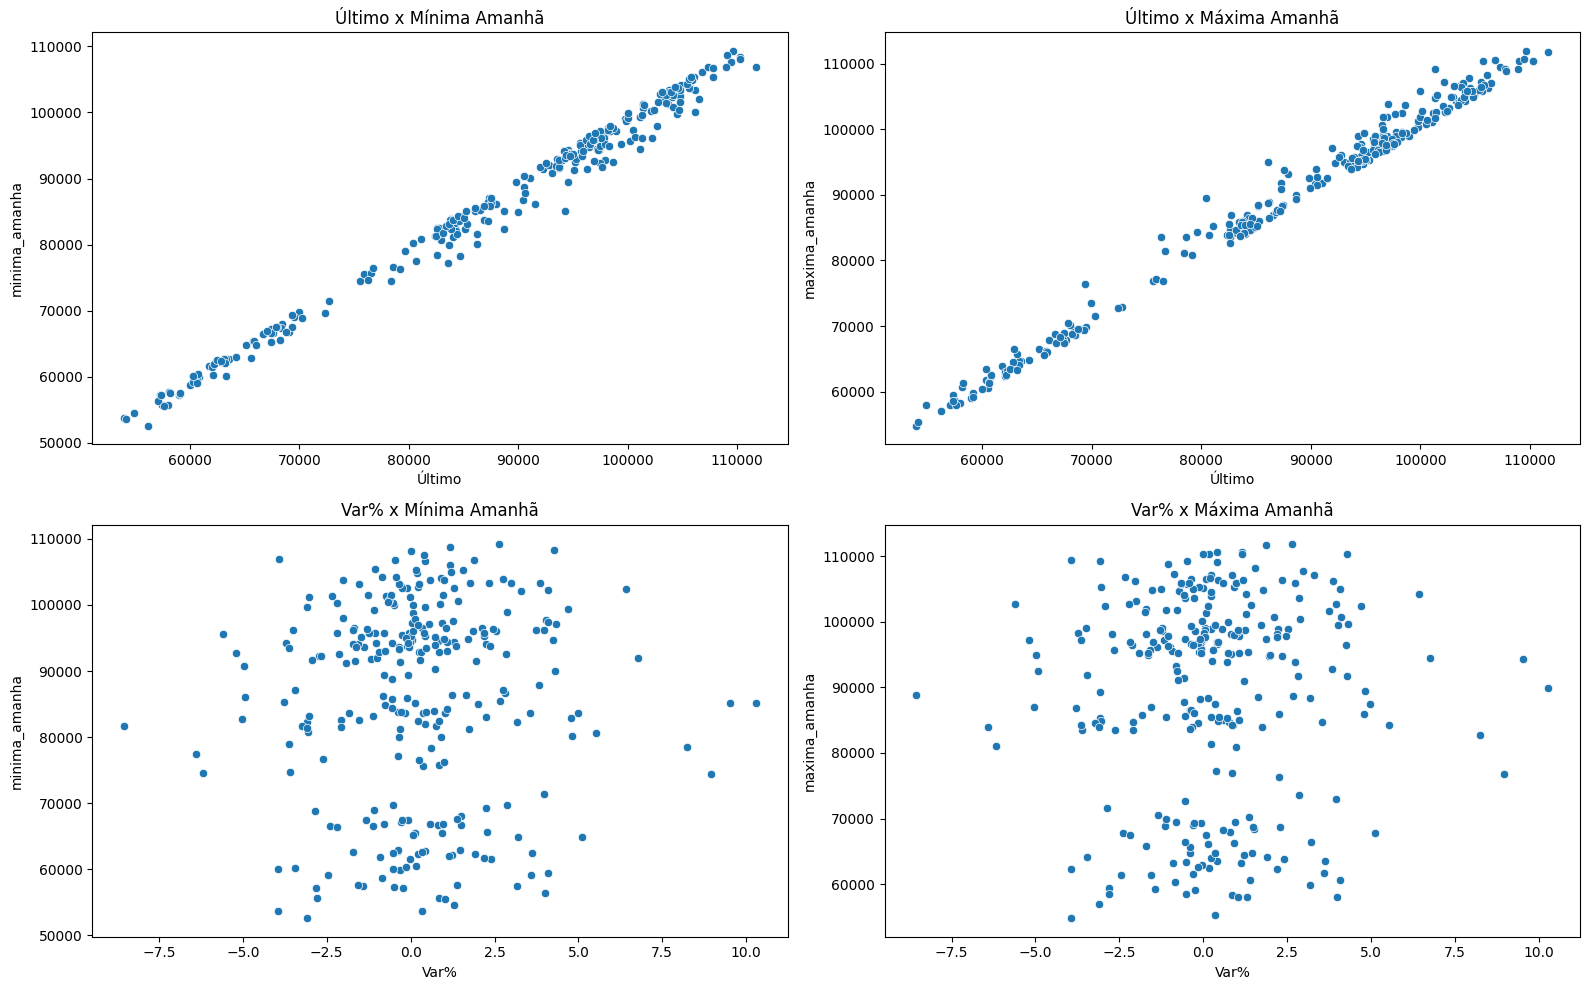

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Estatísticas básicas
print("========== Estatísticas Descritivas ==========")
print(sub_df.describe().T)

# 0.1 Classificação das variáveis
print("\n========== Classificação das Variáveis ==========")
variaveis_numericas = sub_df.select_dtypes(include='number').columns.tolist()
variaveis_booleanas = sub_df.select_dtypes(include='bool').columns.tolist()
variaveis_categoricas = sub_df.select_dtypes(include='object').columns.tolist()

print("Numéricas:", variaveis_numericas)
print("Booleanas:", variaveis_booleanas)
print("Categóricas:", variaveis_categoricas if variaveis_categoricas else "Nenhuma")

# 1. Histogramas para variáveis numéricas
sub_df[variaveis_numericas].hist(bins=30, figsize=(18, 12), edgecolor='black')
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

# 2. Boxplot apenas para Vol_USD
plt.figure(figsize=(10, 2))
sns.boxplot(x=sub_df['Vol_USD'])
plt.title('Boxplot - Volume em Dólares (Vol_USD)')
plt.tight_layout()
plt.show()

# 3. Countplot para a variável booleana 'rompeu_topo_historico'
plt.figure(figsize=(6, 4))
sns.countplot(x='rompeu_topo_historico', data=sub_df)
plt.title('Distribuição - Rompeu Topo Histórico (booleano)')
plt.xlabel('Rompeu Topo Histórico')
plt.ylabel('Contagem')
plt.tight_layout()
plt.show()

# 4. Heatmap de Correlação com legenda de cores
plt.figure(figsize=(14, 10))
corr_matrix = sub_df[variaveis_numericas].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()
plt.show()

# 5. Gráficos de dispersão entre algumas features e os targets
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='Último', y='minima_amanha', data=sub_df)
plt.title('Último x Mínima Amanhã')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Último', y='maxima_amanha', data=sub_df)
plt.title('Último x Máxima Amanhã')

plt.subplot(2, 2, 3)
sns.scatterplot(x='Var%', y='minima_amanha', data=sub_df)
plt.title('Var% x Mínima Amanhã')

plt.subplot(2, 2, 4)
sns.scatterplot(x='Var%', y='maxima_amanha', data=sub_df)
plt.title('Var% x Máxima Amanhã')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Selecionar apenas variáveis numéricas
variaveis_numericas = sub_df.select_dtypes(include='number')

# Calcular média, mediana e moda
media = variaveis_numericas.mean()
mediana = variaveis_numericas.median()
moda = variaveis_numericas.mode().iloc[0]  # Pega a primeira moda se houver múltiplas

# Organizar em um DataFrame bonitinho
estatisticas = pd.DataFrame({
    'Média': media,
    'Mediana': mediana,
    'Moda': moda
})

# Formatar com 2 casas decimais
estatisticas = estatisticas.round(2)

# Exibir
print("========== Estatísticas Descritivas ==========")
print(estatisticas)


========== Estatísticas Descritivas ==========
                           Média       Mediana          Moda
Último              8.738773e+04  9.349955e+04  1.041192e+05
Abertura            8.720722e+04  9.324435e+04  5.396500e+04
Máxima              8.885215e+04  9.495760e+04  5.481920e+04
Mínima              8.561355e+04  9.144795e+04  5.264460e+04
Vol_USD             7.967853e+09  6.832506e+09  1.663936e+09
Var%                2.500000e-01  1.100000e-01 -5.300000e-01
media_movel_max_3   8.867568e+04  9.510047e+04  5.569367e+04
vol_relativo        1.140000e+00  1.010000e+00  2.400000e-01
minima_rel_ultimo  -2.000000e-02 -1.000000e-02 -1.000000e-01
volume_relativo_7d  1.010000e+00  9.900000e-01  1.900000e-01
var_pct_3d          2.500000e-01  2.800000e-01  1.900000e-01
minima_amanha       8.578721e+04  9.151985e+04  5.264460e+04
maxima_amanha       8.903151e+04  9.498265e+04  5.481920e+04


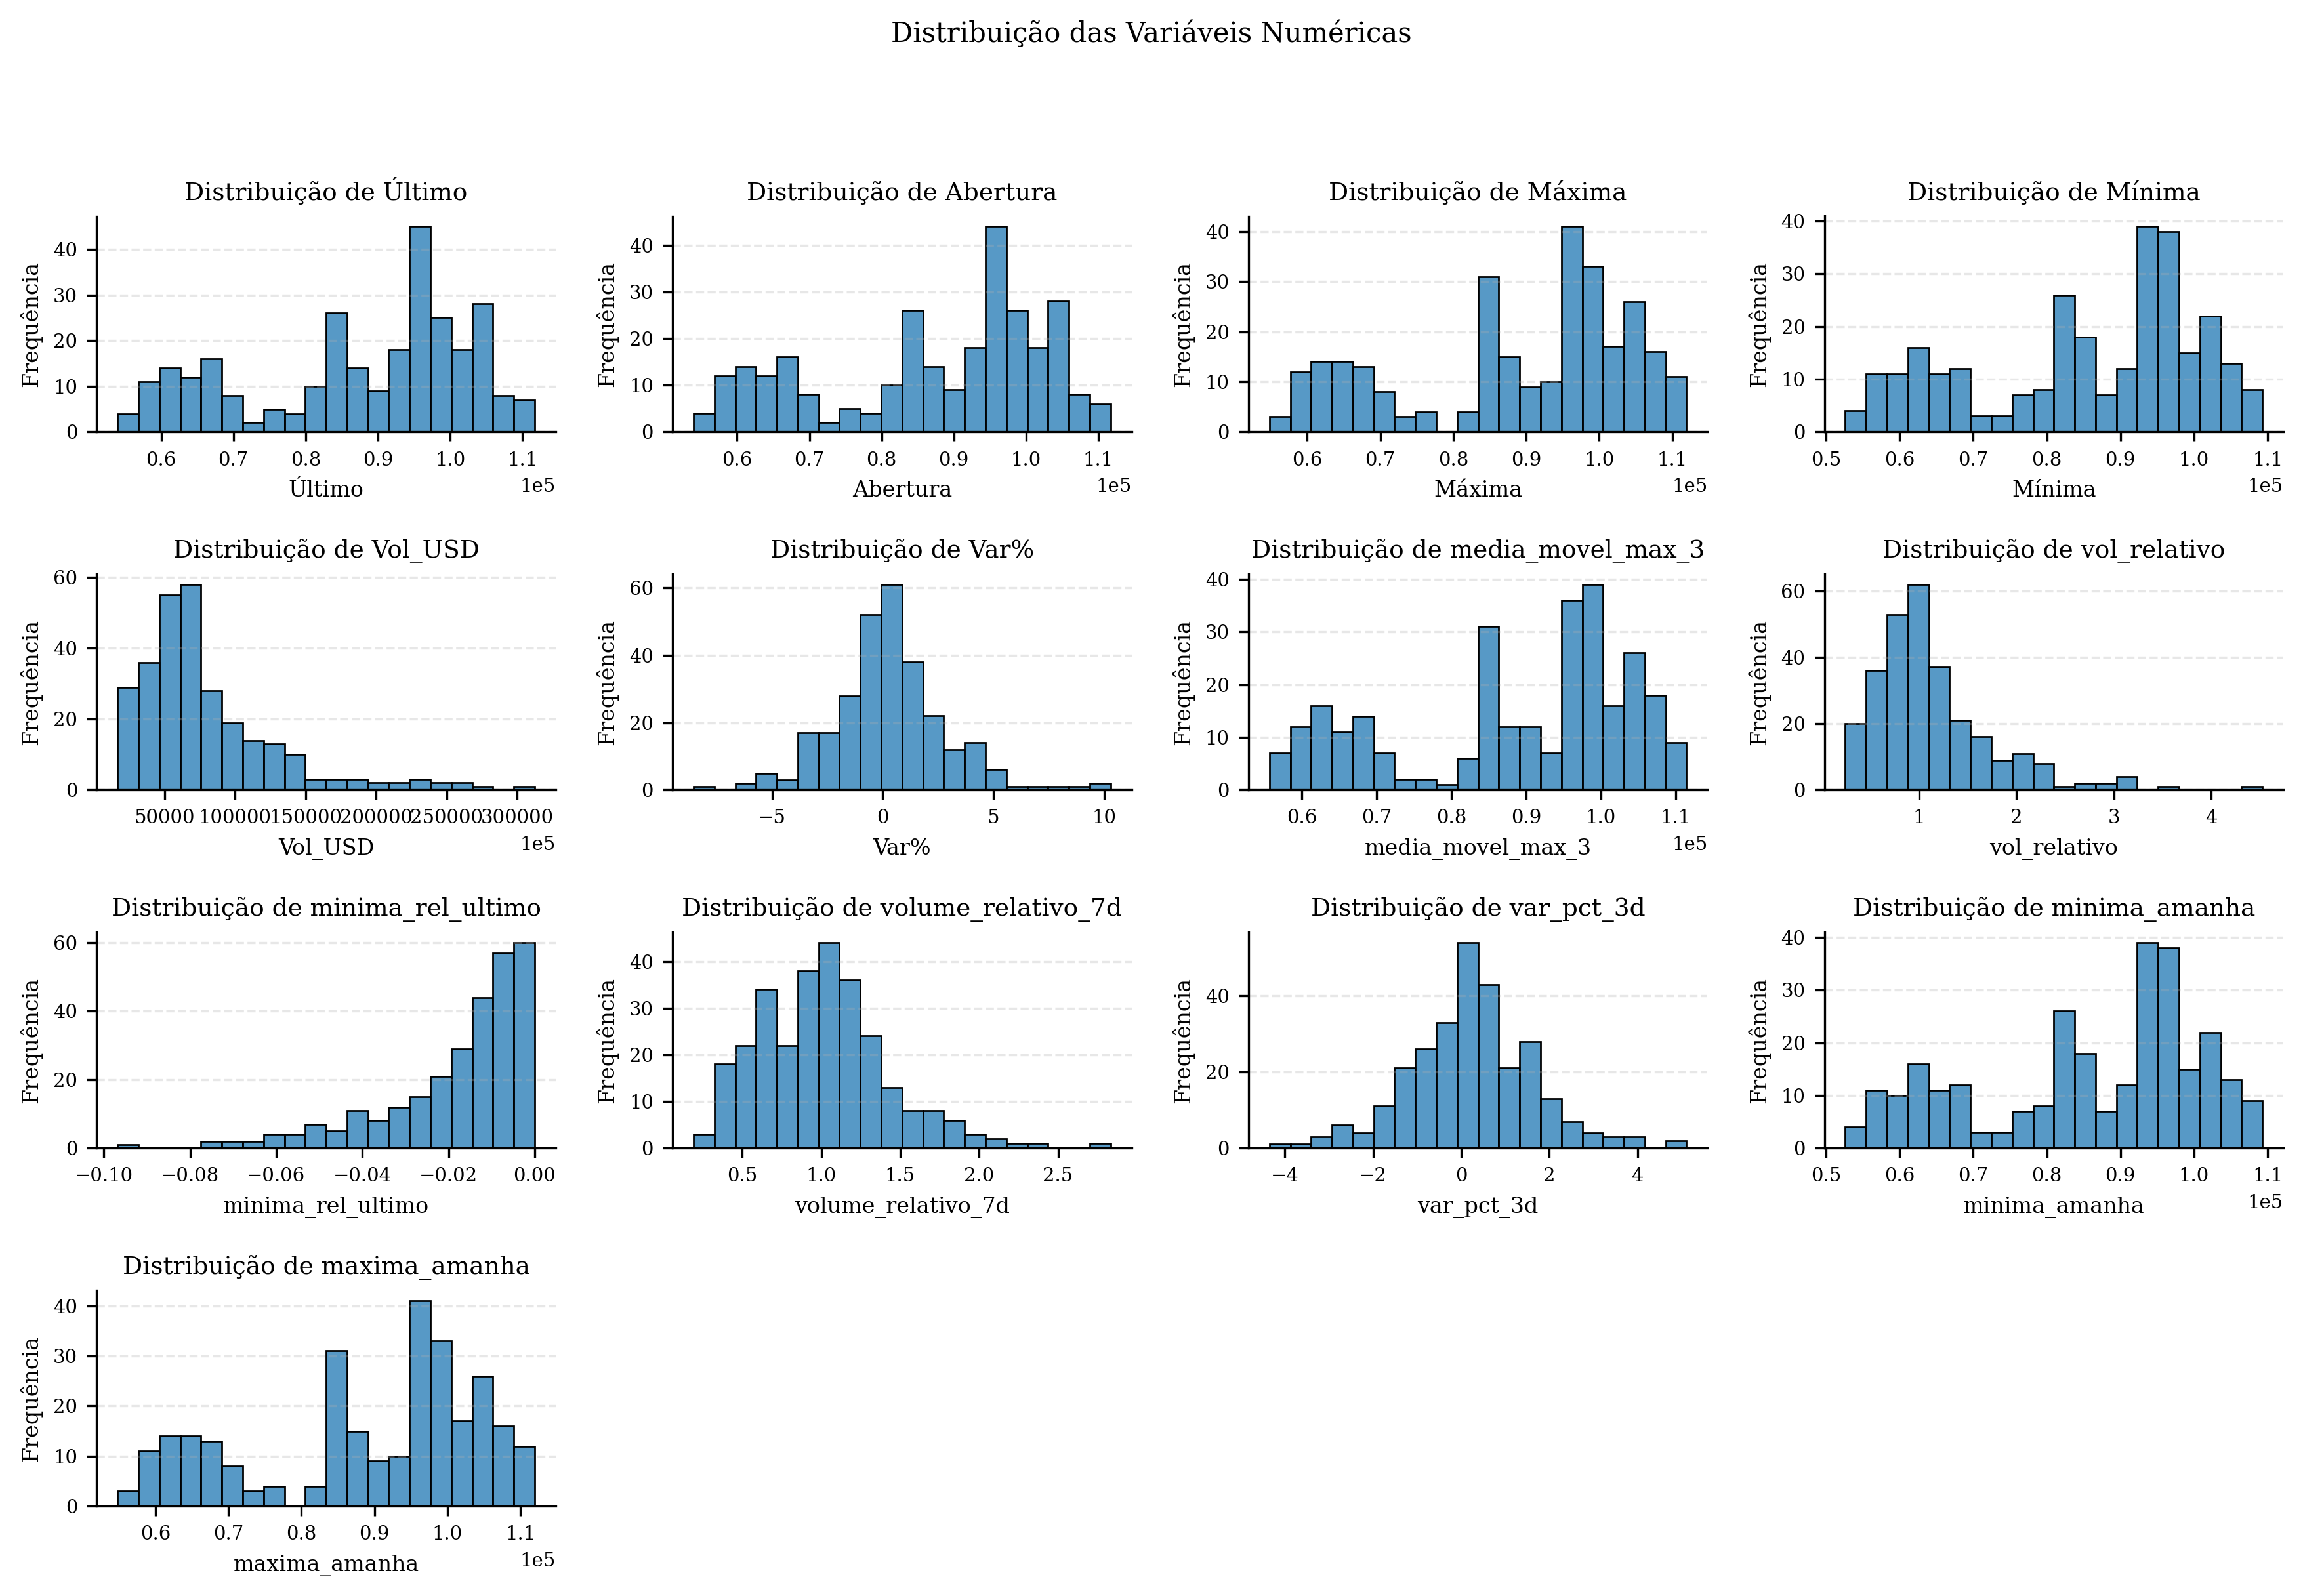

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Configurações ABNT Compacta
ABNT_COMPACT = {
    "font.family": "serif",
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.titlesize": 10,
    "figure.dpi": 300,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
}
rcParams.update(ABNT_COMPACT)

def format_abnt_axes(ax):
    """Formata eixos conforme normas ABNT versão compacta"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', alpha=0.3, linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=7)

def plot_histograms_abnt_compact(dataframe, numeric_vars, figsize=(12, 8)):
    """Plota histogramas conforme normas ABNT, versão compacta"""

    total = len(numeric_vars)
    n_cols = 4
    n_rows = (total // n_cols) + (total % n_cols > 0)

    fig = plt.figure(figsize=figsize, dpi=300)

    for i, col in enumerate(numeric_vars, 1):
        ax = plt.subplot(n_rows, n_cols, i)

        sns.histplot(dataframe[col], bins=20, kde=False,
                     edgecolor='black', color='#1f77b4', ax=ax)

        ax.set_title(f'Distribuição de {col}', pad=6)
        ax.set_xlabel(col)  # ← Nome no eixo X adicionado aqui
        ax.set_ylabel('Frequência')

        if dataframe[col].max() > 1e5:
            ax.ticklabel_format(style='sci', axis='x', scilimits=(5,5))

        format_abnt_axes(ax)

    plt.suptitle('Distribuição das Variáveis Numéricas', y=1.02, fontsize=10)
    plt.tight_layout(pad=2.0, h_pad=1.5, w_pad=1.5)
    plt.show()

# Uso da função
variaveis_numericas = sub_df.select_dtypes(include='number').columns.tolist()
plot_histograms_abnt_compact(sub_df, variaveis_numericas)


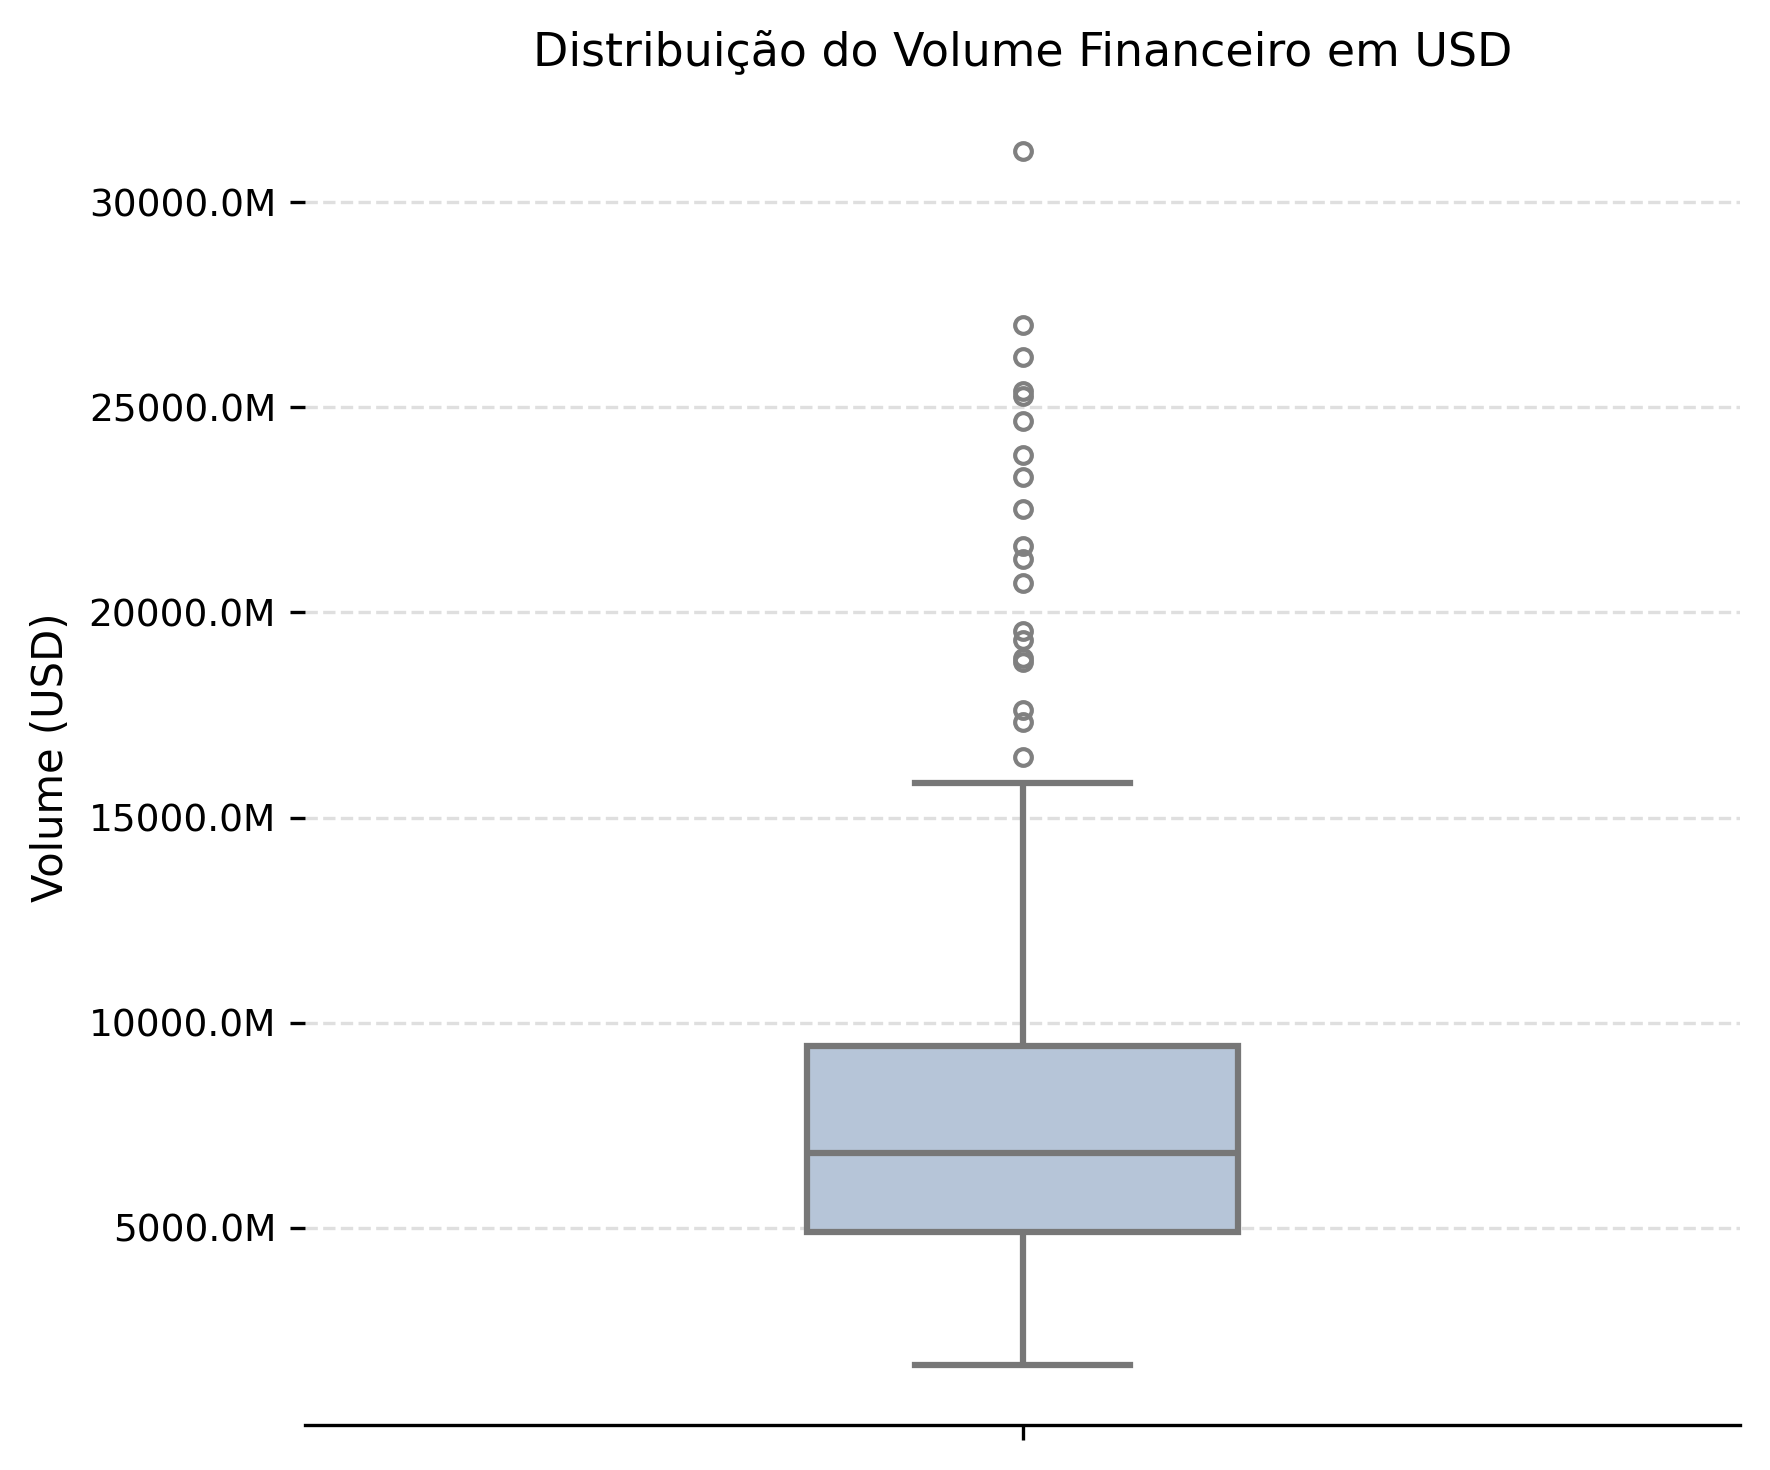

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# ============================
# Configuração ABNT
# ============================
ABNT_CONFIG = {
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "grid.alpha": 0.4,
    "grid.linestyle": "--"
}
rcParams.update(ABNT_CONFIG)

# ============================
# Plotagem do Boxplot (sem legenda)
# ============================
plt.figure(figsize=(6, 5), dpi=300)

sns.boxplot(
    y='Vol_USD',
    data=sub_df,
    width=0.3,
    color='#B0C4DE',
    linewidth=1.5,
    flierprops=dict(
        marker='o',
        markersize=4,
        markerfacecolor='none',
        markeredgecolor='gray'
    )
)

plt.title('Distribuição do Volume Financeiro em USD')
plt.ylabel('Volume (USD)')
plt.xlabel('')

# Grade no eixo y
plt.grid(axis='y', alpha=0.4, linestyle='--')

# Remove bordas desnecessárias
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

# Formatação eixo y → milhões
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()


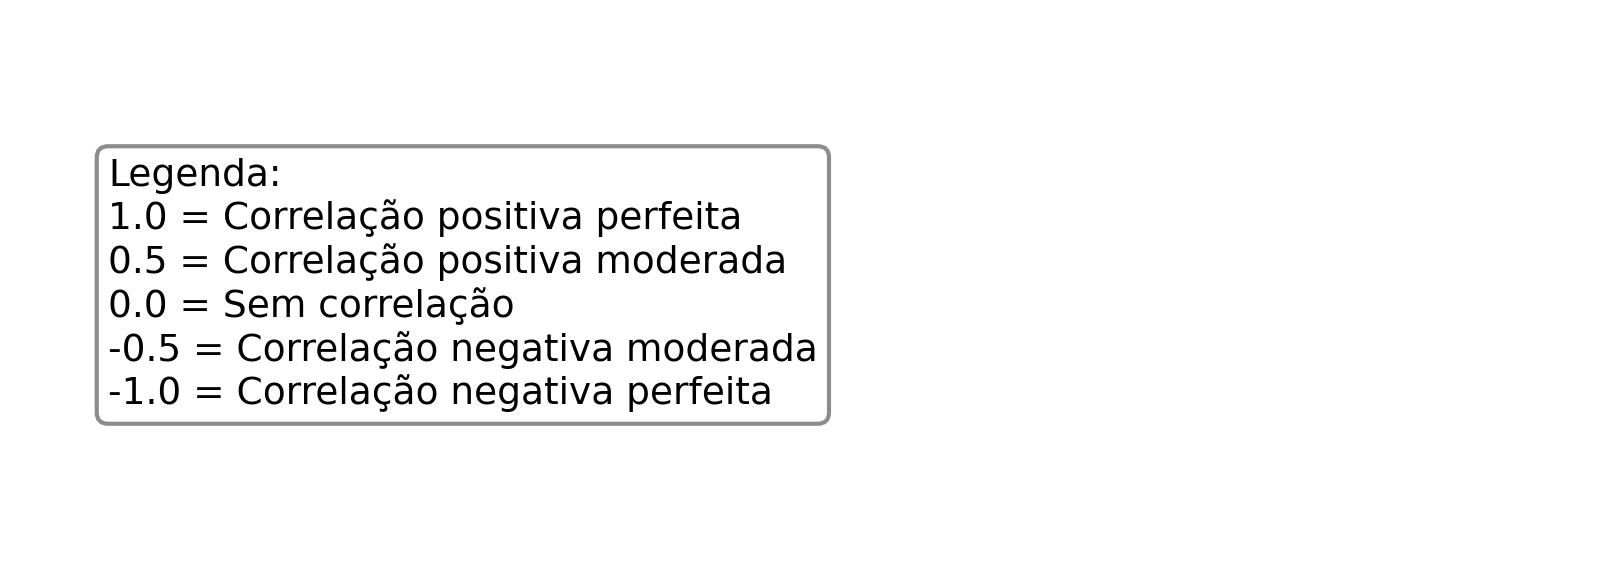

In [ ]:
import matplotlib.pyplot as plt

# ============================
# Criação da imagem da legenda
# ============================
fig, ax = plt.subplots(figsize=(5.5, 2), dpi=300)
ax.axis('off')

# Texto da legenda
texto = (
    'Legenda:\n'
    '1.0 = Correlação positiva perfeita\n'
    '0.5 = Correlação positiva moderada\n'
    '0.0 = Sem correlação\n'
    '-0.5 = Correlação negativa moderada\n'
    '-1.0 = Correlação negativa perfeita'
)

# Texto com caixa estilo arredondado
ax.text(0.05, 0.5, texto, fontsize=9, va='center', ha='left',
        bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray', alpha=0.9))

plt.tight_layout()
plt.show()


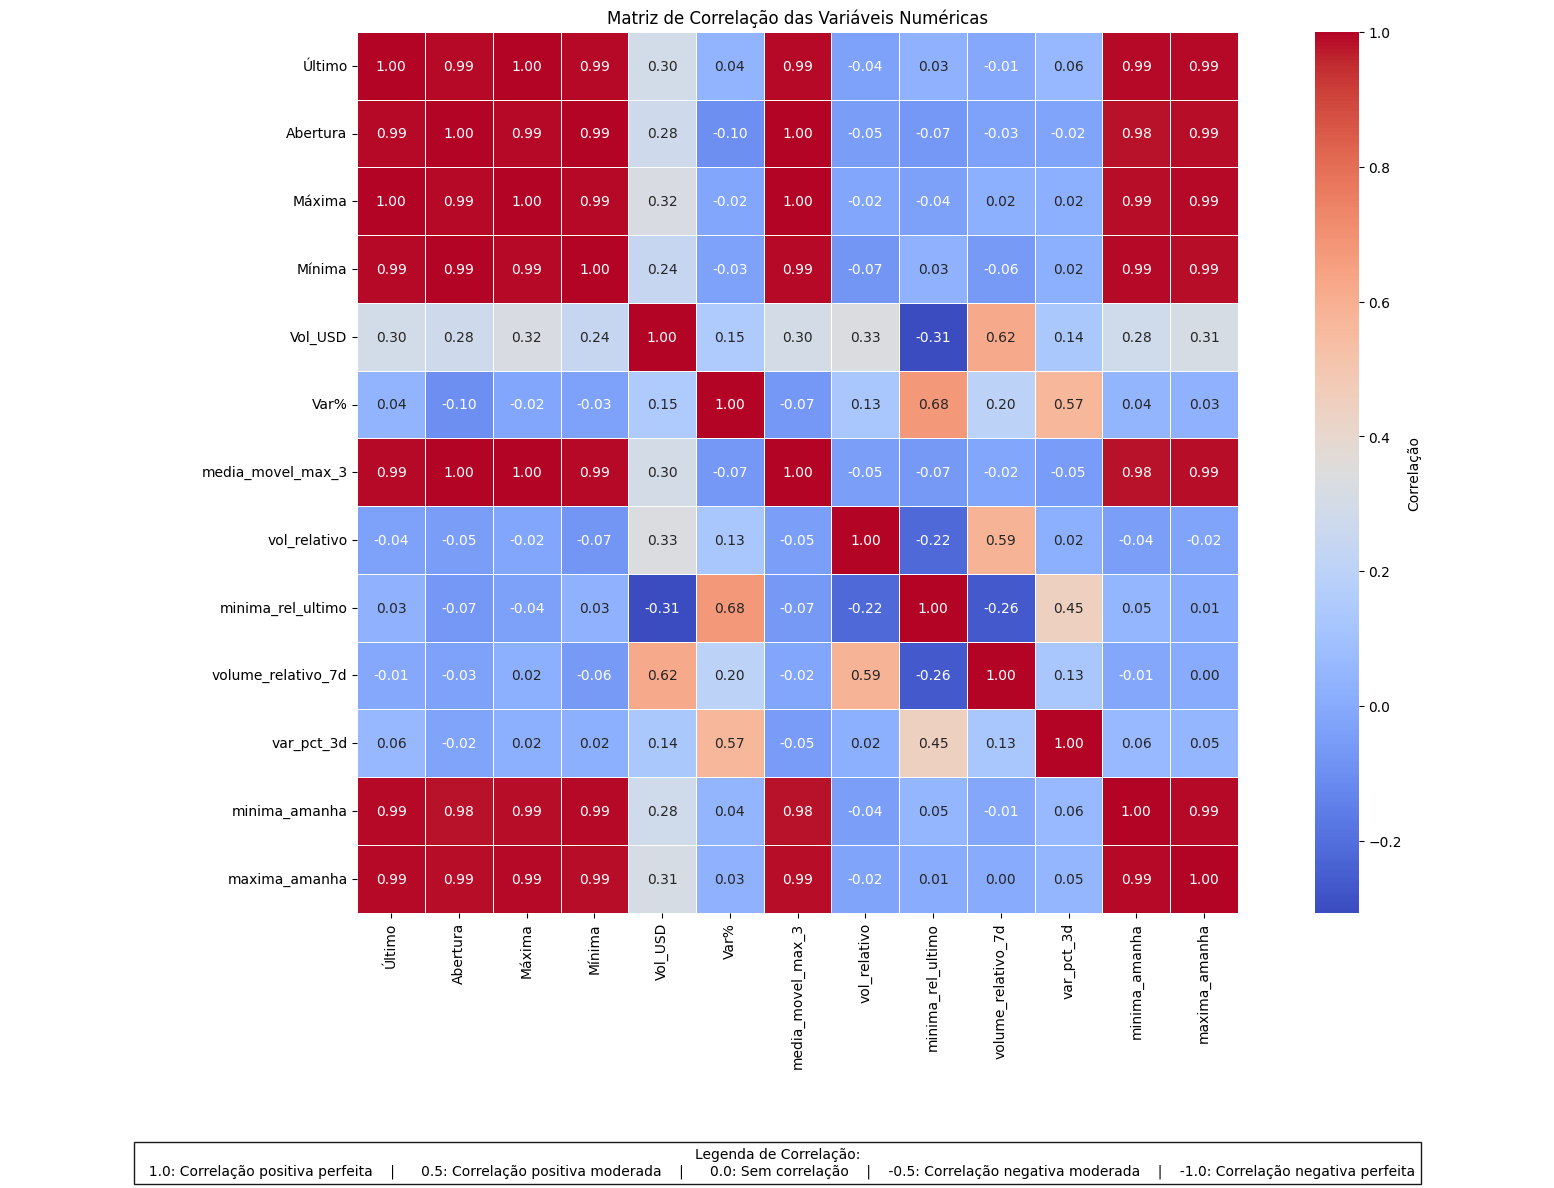

In [ ]:
import matplotlib.gridspec as gridspec

# 4. Heatmap de Correlação com legenda explicativa
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])  # heatmap acima, legenda abaixo

# Heatmap
ax0 = plt.subplot(gs[0])
corr_matrix = sub_df[variaveis_numericas].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Correlação'}, linewidths=0.5, ax=ax0)
ax0.set_title('Matriz de Correlação das Variáveis Numéricas')

# Legenda explicativa
ax1 = plt.subplot(gs[1])
ax1.axis('off')  # Remove os eixos

# Texto da legenda
legenda_texto = (
    "Legenda de Correlação:\n"
    "  1.0: Correlação positiva perfeita    |    "
    "  0.5: Correlação positiva moderada    |    "
    "  0.0: Sem correlação    |    "
    "-0.5: Correlação negativa moderada    |    "
    "-1.0: Correlação negativa perfeita"
)

ax1.text(0.5, 0.1, legenda_texto, ha='center', va='center', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()


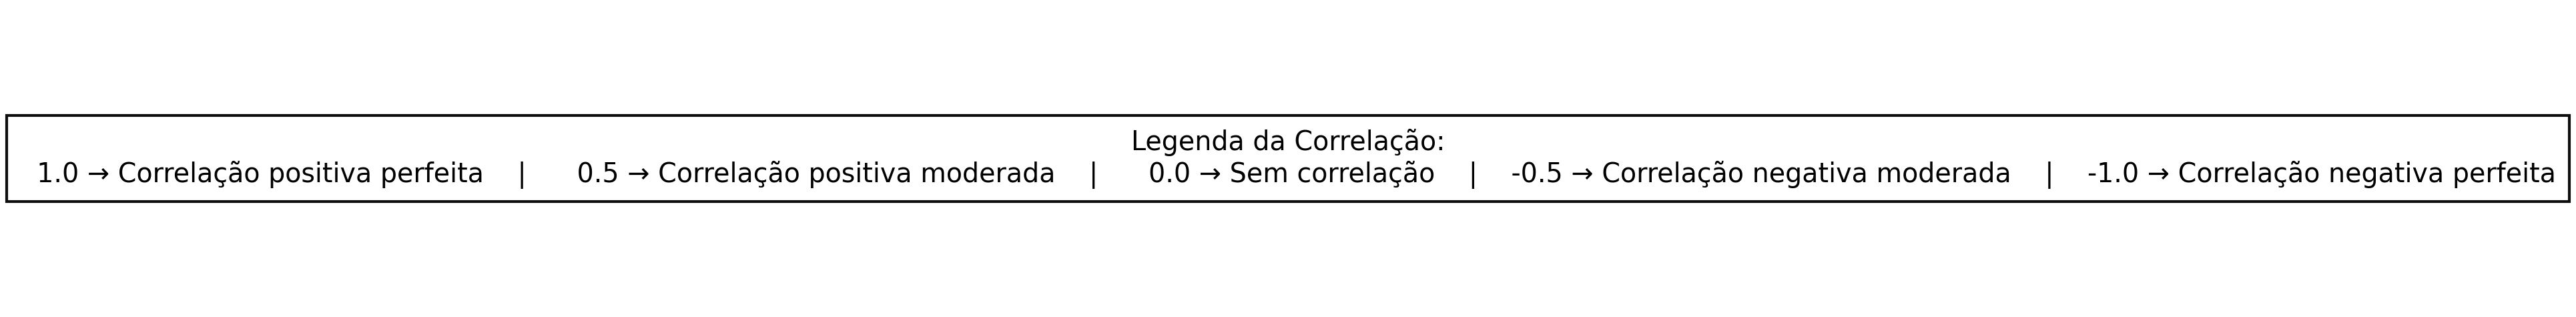

In [ ]:
import matplotlib.pyplot as plt

# ==========================
# Criação da imagem da legenda da correlação
# ==========================
fig, ax = plt.subplots(figsize=(5.5, 1.8), dpi=300)
ax.axis('off')

# Texto da legenda
legenda_texto = (
    "Legenda da Correlação:\n"
    "  1.0 → Correlação positiva perfeita    |    "
    "  0.5 → Correlação positiva moderada    |    "
    "  0.0 → Sem correlação    |    "
    "-0.5 → Correlação negativa moderada    |    "
    "-1.0 → Correlação negativa perfeita"
)

# Texto dentro da caixinha quadrada
ax.text(
    0.5, 0.5, legenda_texto,
    ha='center', va='center',
    fontsize=9.5,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='square,pad=0.5',
        alpha=0.95,
        linewidth=1
    )
)

plt.tight_layout()
plt.show()


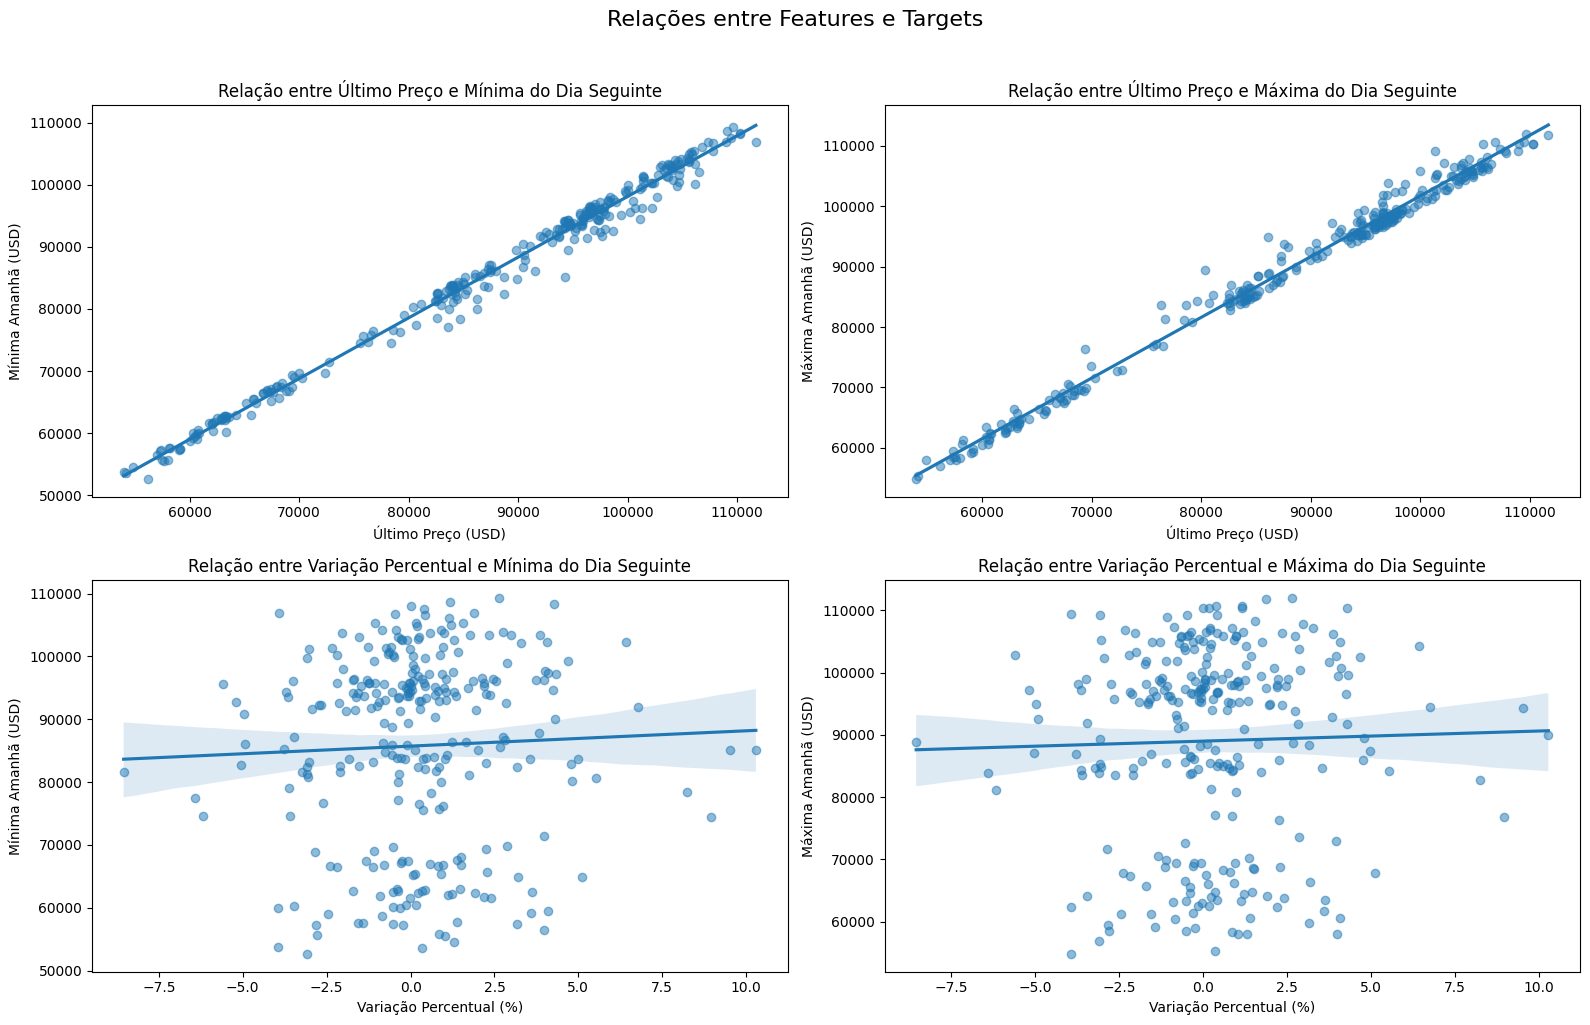

In [ ]:
## 6. Gráficos de Dispersão Aprimorados
plt.figure(figsize=(16, 10))

# Plot 1: Último x Mínima Amanhã
plt.subplot(2, 2, 1)
sns.regplot(x='Último', y='minima_amanha', data=sub_df, scatter_kws={'alpha':0.5})
plt.title('Relação entre Último Preço e Mínima do Dia Seguinte', fontsize=12)
plt.xlabel('Último Preço (USD)')
plt.ylabel('Mínima Amanhã (USD)')

# Plot 2: Último x Máxima Amanhã
plt.subplot(2, 2, 2)
sns.regplot(x='Último', y='maxima_amanha', data=sub_df, scatter_kws={'alpha':0.5})
plt.title('Relação entre Último Preço e Máxima do Dia Seguinte', fontsize=12)
plt.xlabel('Último Preço (USD)')
plt.ylabel('Máxima Amanhã (USD)')

# Plot 3: Var% x Mínima Amanhã
plt.subplot(2, 2, 3)
sns.regplot(x='Var%', y='minima_amanha', data=sub_df, scatter_kws={'alpha':0.5})
plt.title('Relação entre Variação Percentual e Mínima do Dia Seguinte', fontsize=12)
plt.xlabel('Variação Percentual (%)')
plt.ylabel('Mínima Amanhã (USD)')

# Plot 4: Var% x Máxima Amanhã
plt.subplot(2, 2, 4)
sns.regplot(x='Var%', y='maxima_amanha', data=sub_df, scatter_kws={'alpha':0.5})
plt.title('Relação entre Variação Percentual e Máxima do Dia Seguinte', fontsize=12)
plt.xlabel('Variação Percentual (%)')
plt.ylabel('Máxima Amanhã (USD)')

plt.suptitle('Relações entre Features e Targets', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()